# SAFETY RECOMMENDER

I put together this notebook to test different algorithms with a relatively small number of features in our data - those most like to impact. The main purpose was for me to become familiar with the general process and play around with different models.  

This is based on the following:  1) The class Occupancy notebook; 2) The book Introduction to Machine Learning with Python; 3) The class Wheat Classification notebook.  

This version includes previously-planned updates to:  1) Put data into a bunch that reads the json file, etc. for features, target so that some of the last models will work; 2) Test additional models in the "Intro" book; 3) Add features; 4) Look at creating a data set that compares crime data for a week with the all months, days and hours for the same week to create a set of records that can be used to show likelihood of a crime being committed at the latitude and longitude for a DC address (e.g., includes hours that crimes did and did not occur for a limited time period). If time remains I'll look on how to prepare this in the notebook so it will be current instead of just in a one-time .csv file that we can use for testing.  

## Machine Learning Models Overview

This chart helps in the model selection process. It comes from information in the "Intro" book.  It needs to be built out more based on class notes and presentations. A classmate started one previously and might want to collaborate.  

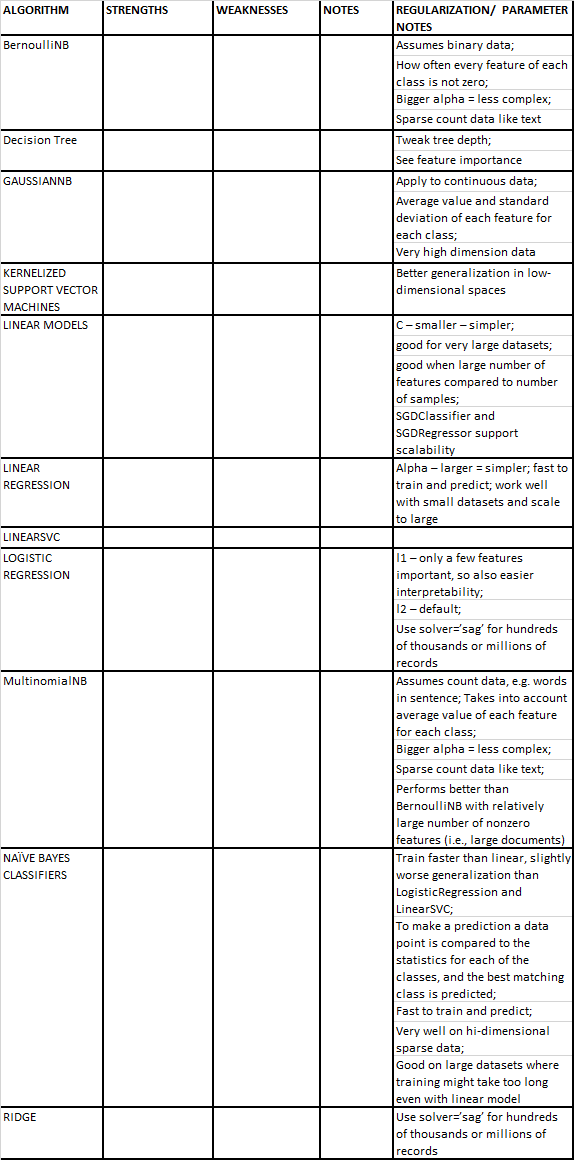

## Data Ingestion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
import IPython
import sys
import os
import json
import time
import pickle
import requests
import pandas.io.sql as pd_sql
import sqlite3 as sql
import csv
import graphviz
from scipy import stats


from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime

from sklearn.datasets.base import Bunch

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer 
from sklearn.base import BaseEstimator, TransformerMixin 

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import GradientBoostingClassifier 
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassBalance, ConfusionMatrix, ClassificationReport
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split as tts 

%matplotlib inline

C:\Users\Judith\Anaconda3\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.0.3) doesn't match a supported version!
  RequestsDependencyWarning)
C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Panda settings
#Pandas will not display all columns in our data when using the head() function without this
pd.set_option('max_columns',50) 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
#this takes about 10 seconds
URL = "https://datagate.dc.gov/search/open/crimes?daterange=2years&details=true&format=csv"

def fetch_data(fname="dc-crimes-search-results.csv"):
    """
    Helper method to retrieve the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

DATA = fetch_data()


In [4]:
def load_df(path=DATA):
    return pd.read_csv(path)

In [5]:
df = load_df()

## Data Exploration 1

In [6]:
df.columns

Index(['NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'offensegroup', 'LONGITUDE',
       'END_DATE', 'offense-text', 'SHIFT', 'YBLOCK', 'DISTRICT', 'WARD',
       'YEAR', 'offensekey', 'BID', 'sector', 'PSA', 'ucr-rank', 'BLOCK_GROUP',
       'VOTING_PRECINCT', 'XBLOCK', 'BLOCK', 'START_DATE', 'CCN', 'OFFENSE',
       'ANC', 'REPORT_DAT', 'METHOD', 'location', 'LATITUDE'],
      dtype='object')

In [7]:
#summary statistics on the data.

df.describe()

,CENSUS_TRACT,LONGITUDE,YBLOCK,DISTRICT,WARD,YEAR,PSA,ucr-rank,XBLOCK,CCN,LATITUDE
count,68150.00000,68310.000000,68310.000000,68288.000000,68310.000000,68310.000000,68282.000000,68310.000000,68310.000000,6.831000e+04,68310.000000
mean,6246.37573,-77.007652,137647.594082,3.672563,4.423130,2016.850139,371.807490,6.054692,399336.910601,1.697492e+07,38.906681
std,3118.87730,0.036111,3362.312692,1.952946,2.338126,0.702458,195.112437,1.296558,3131.962109,7.695922e+05,0.030288
min,100.00000,-77.113642,127300.000000,1.000000,1.000000,2016.000000,101.000000,1.000000,390147.000000,2.111617e+06,38.813471
25%,3600.00000,-77.031224,136119.000000,2.000000,2.000000,2016.000000,206.000000,6.000000,397293.000000,1.619323e+07,38.892892
50%,7000.00000,-77.012181,137598.000000,3.000000,5.000000,2017.000000,308.000000,6.000000,398943.000000,1.708079e+07,38.906228
75%,9000.00000,-76.985441,139614.000000,5.000000,6.000000,2017.000000,506.000000,7.000000,401264.000000,1.720006e+07,38.924398
max,11100.00000,-76.910021,147292.000000,7.000000,8.000000,2018.000000,708.000000,9.000000,407806.000000,8.501717e+07,38.993560


## Data Wrangling 1 -- Parse Start Date into Month, Day, Hour

In [8]:
import datetime

In [9]:
#Create a new column with the datetime month
def label_month (row):
    startdate = (row['START_DATE'] ).replace("Z","")
    startdate2 = datetime.datetime.strptime(startdate, "%Y-%m-%dT%H:%M:%S.%f")
    return startdate2.month


In [10]:
df['start_month'] = df.apply (lambda row: label_month (row),axis=1)
#This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [11]:
#Create a new column with the datetime day
def label_day (row):
    startdate = (row['START_DATE'] ).replace("Z","")
    startdate2 = datetime.datetime.strptime(startdate, "%Y-%m-%dT%H:%M:%S.%f")
    return startdate2.day


In [12]:
df['start_day'] = df.apply (lambda row: label_day (row),axis=1)
#This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [13]:
#Create a new column with the datetime hour
def label_hour (row):
    startdate = (row['START_DATE'] ).replace("Z","")
    startdate2 = datetime.datetime.strptime(startdate, "%Y-%m-%dT%H:%M:%S.%f")
    return startdate2.hour


In [14]:
df['start_hour'] = df.apply (lambda row: label_hour (row),axis=1)
# This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [15]:
#Create a new column with the street number begin
#def label_street_number_begin (row):
#    bl = row['BLOCK']
#    numberbegin = 0
#    if not " and " in bl:       
#        bl_no_block = (bl.replace("block of ", ""))
#        split_block = bl_no_block.split('-',1) 
#        no1 = split_block[0]
#        if no1.isdigit():
#            numberbegin = no1
#        #rest1 = split_block[-1].lstrip()
#        #split_block2 = rest1.split(' ',1)
#        #no2 = split_block2[0]
#    return numberbegin

In [16]:
#df['street_number_begin'] = df.apply (lambda row: label_street_number_begin (row),axis=1)
# This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [17]:
#Create a new column with the street number end
#def label_street_number_end (row):
#    bl = row['BLOCK']
#    numberend = 0
#    if not " and " in bl:       
#        bl_no_block = (bl.replace("block of ", ""))
#        split_block = bl_no_block.split('-',1) 
#        #no1 = split_block[0]
#        rest1 = split_block[-1].lstrip()
#        split_block2 = rest1.split(' ',1)
#        no2 = split_block2[0]
#        if no2.isdigit():
#            numberend = no2
#        else:
#            numberend = 0
#    return numberend

In [18]:
#df['street_number_end'] = df.apply (lambda row: label_street_number_end (row),axis=1)
# This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [19]:
#Create a new column with the street name
#def label_street_name (row):
#    bl = row['BLOCK']
#    if not " and " in bl:       
#        bl_no_block = (bl.replace("block of ", ""))
#        split_block = bl_no_block.split('-',1) 
#        #no1 = split_block[0]
#        rest1 = split_block[-1].lstrip()
#        split_block2 = rest1.split(' ',1)
#        #no2 = split_block2[0]
#        street = split_block2[-1]
#    return streetname

In [20]:
#df['street_name'] = df.apply (lambda row: label_street_name (row),axis=1)
# This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [21]:
#Create new column for block street number end

In [22]:
#Create new column for block street name

## Data Wrangling 2 - Add a column with all positive Longitude values for ML purposes

In [23]:
#Create a new column with a positive longitude
def label_longitude2 (row):
    longitude = row['LONGITUDE']
    longitude2 = longitude * -1
    return longitude2

In [24]:
df['longitude2'] = df.apply (lambda row: label_longitude2 (row),axis=1)
# This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [25]:
# See new columns for start month, day, hour, positive longitude
df.columns

Index(['NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'offensegroup', 'LONGITUDE',
       'END_DATE', 'offense-text', 'SHIFT', 'YBLOCK', 'DISTRICT', 'WARD',
       'YEAR', 'offensekey', 'BID', 'sector', 'PSA', 'ucr-rank', 'BLOCK_GROUP',
       'VOTING_PRECINCT', 'XBLOCK', 'BLOCK', 'START_DATE', 'CCN', 'OFFENSE',
       'ANC', 'REPORT_DAT', 'METHOD', 'location', 'LATITUDE', 'start_month',
       'start_day', 'start_hour', 'longitude2'],
      dtype='object')

In [26]:
df.head(10)

,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,END_DATE,offense-text,SHIFT,YBLOCK,DISTRICT,WARD,YEAR,offensekey,BID,sector,PSA,ucr-rank,BLOCK_GROUP,VOTING_PRECINCT,XBLOCK,BLOCK,START_DATE,CCN,OFFENSE,ANC,REPORT_DAT,METHOD,location,LATITUDE,start_month,start_day,start_hour,longitude2
0,cluster 32,7708.0,property,-76.955521,2016-10-04T16:37:29.000,motor vehicle theft,evening,135396.0,6.0,7,2016,property|motor vehicle theft,NaN,6D3,603.0,8,007708 2,precinct 132,403859.0,3500 - 3526 block of minnesota avenue se,2016-10-04T16:09:08.000,16168699,motor vehicle theft,7B,2016-10-05T03:00:47.000Z,others,"38.886402972929169,-76.955523453842957",38.886395,10,4,16,76.955521
1,cluster 4,100.0,property,-77.059614,2016-10-04T17:44:13.000,theft/other,evening,137194.0,2.0,2,2016,property|theft/other,georgetown,2D3,206.0,6,000100 4,precinct 5,394829.0,3000 - 3029 block of k street nw,2016-10-04T17:00:48.000,16168738,theft/other,2E,2016-10-05T01:36:11.000Z,others,"38.902593275715809,-77.059616752356732",38.902585,10,4,17,77.059614
2,cluster 23,8904.0,property,-76.981924,2016-10-04T20:10:43.000,theft/other,evening,136987.0,5.0,5,2016,property|theft/other,NaN,5D3,507.0,6,008904 2,precinct 79,401568.0,1500 - 1599 block of maryland avenue ne,2016-10-04T19:21:09.000,16168845,theft/other,5D,2016-10-05T02:21:19.000Z,others,"38.900742359981244,-76.981925885322667",38.900735,10,4,19,76.981924
3,cluster 29,9601.0,violent,-76.937531,2016-10-14T00:12:56.000,robbery,midnight,138092.0,6.0,7,2016,violent|robbery,NaN,6D1,601.0,4,009601 1,precinct 92,405418.0,1500 1535 block of 45th street ne,2016-10-13T22:45:39.000,16174401,robbery,7D,2016-10-14T05:31:03.000Z,gun,"38.910681288493713,-76.937533164068512",38.910673,10,13,22,76.937531
4,cluster 25,10600.0,violent,-76.995538,2016-10-22T16:40:05.000,robbery,evening,137463.0,5.0,6,2016,violent|robbery,NaN,5D3,506.0,4,010600 1,precinct 83,400387.0,700 - 799 block of florida avenue ne,2016-10-22T16:24:12.000,16180021,robbery,6C,2016-10-22T22:55:30.000Z,gun,"38.90503165003841,-76.995540557600265",38.905024,10,22,16,76.995538
5,cluster 2,3200.0,property,-77.021405,2016-10-22T22:56:31.000,theft f/auto,midnight,140137.0,3.0,1,2016,property|theft f/auto,NaN,3D1,302.0,7,003200 4,precinct 38,398144.0,500 - 699 block of irving street nw,2016-10-22T20:21:52.000,16180127,theft f/auto,1A,2016-10-24T04:29:28.000Z,others,"38.929118054612083,-77.021407353091945",38.929110,10,22,20,77.021405
6,cluster 31,7807.0,property,-76.922953,NaN,theft/other,midnight,137294.0,6.0,7,2016,property|theft/other,NaN,6D1,608.0,6,007807 2,precinct 95,406683.0,934 - 1099 block of eastern avenue ne,2016-10-22T21:53:20.000,16180199,theft/other,7C,2016-10-23T04:11:28.000Z,others,"38.903483920886075,-76.922955583391357",38.903476,10,22,21,76.922953
7,cluster 6,10700.0,property,-77.040088,2016-10-23T04:28:53.000,theft f/auto,midnight,137847.0,2.0,2,2016,property|theft f/auto,NaN,2D3,208.0,7,010700 2,precinct 15,396523.0,1700 - 1799 block of massachusetts avenue nw,2016-10-23T01:30:55.000,16180348,theft f/auto,2B,2016-10-23T09:24:07.000Z,others,"38.908484062358717,-77.040090587782586",38.908476,10,23,1,77.040088
8,cluster 17,1804.0,property,-77.031560,2016-10-23T06:00:06.000,theft f/auto,day,144484.0,4.0,4,2016,property|theft f/auto,NaN,4D1,402.0,7,001804 1,precinct 61,397265.0,1300 - 1399 block of tewkesbury place nw,2016-10-22T09:00:04.000,16180372,theft f/auto,4A,2016-10-23T11:46:17.000Z,others,"38.968274741325793,-77.031562108374985",38.968267,10,22,9,77.031560
9,cluster 26,7000.0,property,-76.996185,2016-11-01T10:00:39.000,theft f/auto,day,134740.0,1.0,6,2016,property|theft f/auto,NaN,1D3,106.0,7,007000 1,precinct 90,400331.0,700 - 753 block of 7th street se,2016-11-01T08:30:07.000,16186247,theft f/auto,6B,2016-11-01T15:26:46.000Z,others,"38.880501876434913,-76.996187492452577",38.880494,11,1,8,76.996185


## Data Exploration 2 - UCR Rank

Look at ucrrank (Uniform Crime Report Rank). DC uses this index (1-9) to rank crime severity. This is how the ucrrank relates to crime detail: 

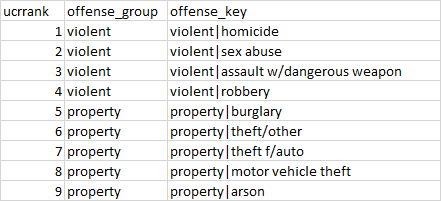

Notice that a ucrrank of 1 is assigned to the most serious type of crime and 9 to the least serious.  

In [27]:
# Use pandas to get the median of the ucrrank column. DataFrame.median(axis=None, skipna=None, level=None, numeric_only=None, **kwargs)[source]
df['ucr-rank'].median()

6.0

In [28]:
# Use pandas to find the number of unique values in the ucrrank column. Series.nunique(dropna=True)[source]¶
df['ucr-rank'].nunique()

9

In [29]:
df.dtypes

NEIGHBORHOOD_CLUSTER     object
CENSUS_TRACT            float64
offensegroup             object
LONGITUDE               float64
END_DATE                 object
offense-text             object
SHIFT                    object
YBLOCK                  float64
DISTRICT                float64
WARD                      int64
YEAR                      int64
offensekey               object
BID                      object
sector                   object
PSA                     float64
ucr-rank                  int64
BLOCK_GROUP              object
VOTING_PRECINCT          object
XBLOCK                  float64
BLOCK                    object
START_DATE               object
CCN                       int64
OFFENSE                  object
ANC                      object
REPORT_DAT               object
METHOD                   object
location                 object
LATITUDE                float64
start_month               int64
start_day                 int64
start_hour                int64
longitud

In [30]:
# Use pandas to count the number of each unique ucrrank value.
df['ucr-rank'].value_counts()

6    28856
7    21702
8     5011
4     4647
3     3854
5     3339
2      632
1      259
9       10
Name: ucr-rank, dtype: int64

## Visualize the Data
Now let's look at two histograms of the ```Fare``` data. In the first, we'll set ```bins=10``` and in the second ```bin=50```. Which one do you find the most helpful? What are you able to tell about the range of fares paid by the passengers from the histograms?

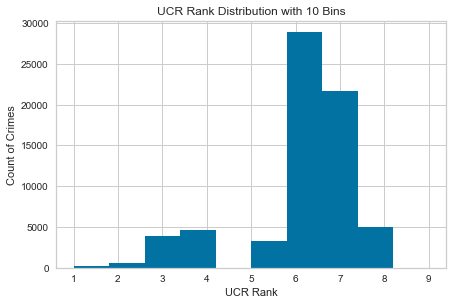

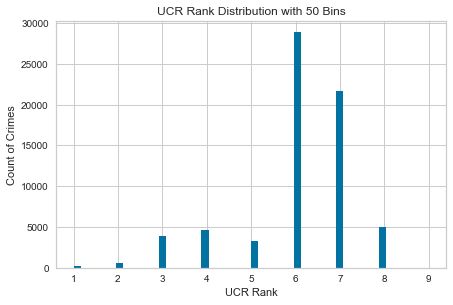

In [31]:
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(211)
ax.hist(df['ucr-rank'], bins=10, range=(df['ucr-rank'].min(),df['ucr-rank'].max()))
plt.title('UCR Rank Distribution with 10 Bins')
plt.xlabel('UCR Rank')
plt.ylabel('Count of Crimes')
plt.show()

fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(212)
ax.hist(df['ucr-rank'], bins=50, range=(df['ucr-rank'].min(),df['ucr-rank'].max()))
plt.title('UCR Rank Distribution with 50 Bins')
plt.xlabel('UCR Rank')
plt.ylabel('Count of Crimes')
plt.show()

## Delete Features

Reduce dataframe to only numerics as required for machine learning. I will review the deletions in the future in case it would help to convert some categorical features like offense and offense group in future versions.  

In [32]:
df2 = df.drop(['NEIGHBORHOOD_CLUSTER', 'LONGITUDE', 'VOTING_PRECINCT','START_DATE', 'offensegroup','END_DATE','offense-text','SHIFT','YBLOCK','DISTRICT','offensekey','BID','sector','PSA','BLOCK_GROUP','BLOCK','OFFENSE','ANC','REPORT_DAT','METHOD','location'], axis=1)

In [33]:
df2.head(10)

,CENSUS_TRACT,WARD,YEAR,ucr-rank,XBLOCK,CCN,LATITUDE,start_month,start_day,start_hour,longitude2
0,7708.0,7,2016,8,403859.0,16168699,38.886395,10,4,16,76.955521
1,100.0,2,2016,6,394829.0,16168738,38.902585,10,4,17,77.059614
2,8904.0,5,2016,6,401568.0,16168845,38.900735,10,4,19,76.981924
3,9601.0,7,2016,4,405418.0,16174401,38.910673,10,13,22,76.937531
4,10600.0,6,2016,4,400387.0,16180021,38.905024,10,22,16,76.995538
5,3200.0,1,2016,7,398144.0,16180127,38.929110,10,22,20,77.021405
6,7807.0,7,2016,6,406683.0,16180199,38.903476,10,22,21,76.922953
7,10700.0,2,2016,7,396523.0,16180348,38.908476,10,23,1,77.040088
8,1804.0,4,2016,7,397265.0,16180372,38.968267,10,22,9,77.031560
9,7000.0,6,2016,7,400331.0,16186247,38.880494,11,1,8,76.996185


In [34]:
#Change column order to put ucr-rank (target) last
df3 = df2.reindex(columns=["CENSUS_TRACT", "WARD", "LATITUDE", "start_month", "start_day", "start_hour", "longitude2", "ucr-rank"])

In [35]:
df3.head(10)

,CENSUS_TRACT,WARD,LATITUDE,start_month,start_day,start_hour,longitude2,ucr-rank
0,7708.0,7,38.886395,10,4,16,76.955521,8
1,100.0,2,38.902585,10,4,17,77.059614,6
2,8904.0,5,38.900735,10,4,19,76.981924,6
3,9601.0,7,38.910673,10,13,22,76.937531,4
4,10600.0,6,38.905024,10,22,16,76.995538,4
5,3200.0,1,38.929110,10,22,20,77.021405,7
6,7807.0,7,38.903476,10,22,21,76.922953,6
7,10700.0,2,38.908476,10,23,1,77.040088,7
8,1804.0,4,38.968267,10,22,9,77.031560,7
9,7000.0,6,38.880494,11,1,8,76.996185,7


In [36]:
print(df3.shape)

(68310, 8)


## Save to text file and csv file

In [37]:
filename = 'crime.csv'
df3.to_csv(filename, index = False)

In [38]:
filename = 'crime.txt'
np.savetxt(filename, df3.values, fmt='%s')

In [39]:
df3.columns

Index(['CENSUS_TRACT', 'WARD', 'LATITUDE', 'start_month', 'start_day',
       'start_hour', 'longitude2', 'ucr-rank'],
      dtype='object')

# Join to Census Data for More Features Based on Census Tract

In [40]:
#census_dc_wellbeing.csv
censusdata = pd.read_csv('census_dc_wellbeing.csv')

In [41]:
print(censusdata.shape)
print(list(censusdata.columns))

(180, 102)
['GEO2010', 'PctPoorPersons_1980', 'PctPoorPersons_1990', 'PctPoorPersons_2000', 'PctPoorPersons_2011_15', 'PctPoorChildren_1990', 'PctPoorChildren_2000', 'PctPoorChildren_2011_15', 'PctPoorElderly_1990', 'PctPoorElderly_2000', 'PctPoorElderly_2011_15', 'PctUnemployed_1980', 'PctUnemployed_1990', 'PctUnemployed_2000', 'PctUnemployed_2011_15', 'Pct16andOverEmployed_1980', 'Pct16andOverEmployed_1990', 'Pct16andOverEmployed_2000', 'Pct16andOverEmployed_2011_15', 'Pct25andOverWoutHS_1980', 'Pct25andOverWoutHS_1990', 'Pct25andOverWoutHS_2000', 'Pct25andOverWoutHS_2011_15', 'PctHshldPhone_2000', 'PctHshldPhone_2011_15', 'PctHshldCar_2000', 'PctHshldCar_2011_15', 'AvgFamilyIncAdj_1980', 'AvgFamilyIncAdj_1990', 'AvgFamilyIncAdj_2000', 'AvgFamilyIncAdj_2011_15', 'PctChgAvgFamilyIncAdj_1980_1990', 'PctChgAvgFamilyIncAdj_1990_2000', 'PctChgAvgFamilyIncA_2000_2011_15', 'fs_client_2000', 'fs_client_2001', 'fs_client_2002', 'fs_client_2003', 'fs_client_2004', 'fs_client_2005', 'fs_client_

In [42]:
censusdata.head(5)

,GEO2010,PctPoorPersons_1980,PctPoorPersons_1990,PctPoorPersons_2000,PctPoorPersons_2011_15,PctPoorChildren_1990,PctPoorChildren_2000,PctPoorChildren_2011_15,PctPoorElderly_1990,PctPoorElderly_2000,PctPoorElderly_2011_15,PctUnemployed_1980,PctUnemployed_1990,PctUnemployed_2000,PctUnemployed_2011_15,Pct16andOverEmployed_1980,Pct16andOverEmployed_1990,Pct16andOverEmployed_2000,Pct16andOverEmployed_2011_15,Pct25andOverWoutHS_1980,Pct25andOverWoutHS_1990,Pct25andOverWoutHS_2000,Pct25andOverWoutHS_2011_15,PctHshldPhone_2000,PctHshldPhone_2011_15,PctHshldCar_2000,PctHshldCar_2011_15,AvgFamilyIncAdj_1980,AvgFamilyIncAdj_1990,AvgFamilyIncAdj_2000,AvgFamilyIncAdj_2011_15,PctChgAvgFamilyIncAdj_1980_1990,PctChgAvgFamilyIncAdj_1990_2000,PctChgAvgFamilyIncA_2000_2011_15,fs_client_2000,fs_client_2001,fs_client_2002,fs_client_2003,fs_client_2004,fs_client_2005,fs_client_2006,fs_client_2007,fs_client_2008,fs_client_2009,fs_client_2010,fs_client_2011,fs_client_2012,fs_client_2013,fs_client_2014,fs_client_2015,fs_client_2016,tanf_client_2000,tanf_client_2001,tanf_client_2002,tanf_client_2003,tanf_client_2004,tanf_client_2005,tanf_client_2006,tanf_client_2007,tanf_client_2008,tanf_client_2009,tanf_client_2010,tanf_client_2011,tanf_client_2012,tanf_client_2013,tanf_client_2014,tanf_client_2015,tanf_client_2016,Rate_crimes_pt1_violent_2000,Rate_crimes_pt1_violent_2001,Rate_crimes_pt1_violent_2002,Rate_crimes_pt1_violent_2003,Rate_crimes_pt1_violent_2004,Rate_crimes_pt1_violent_2005,Rate_crimes_pt1_violent_2006,Rate_crimes_pt1_violent_2007,Rate_crimes_pt1_violent_2008,Rate_crimes_pt1_violent_2009,Rate_crimes_pt1_violent_2010,Rate_crimes_pt1_violent_2011,Rate_crimes_pt1_violent_2012,Rate_crimes_pt1_violent_2013,Rate_crimes_pt1_violent_2014,Rate_crimes_pt1_violent_2015,Rate_crimes_pt1_violent_2016,Rate_crimes_pt1_property_2000,Rate_crimes_pt1_property_2001,Rate_crimes_pt1_property_2002,Rate_crimes_pt1_property_2003,Rate_crimes_pt1_property_2004,Rate_crimes_pt1_property_2005,Rate_crimes_pt1_property_2006,Rate_crimes_pt1_property_2007,Rate_crimes_pt1_property_2008,Rate_crimes_pt1_property_2009,Rate_crimes_pt1_property_2010,Rate_crimes_pt1_property_2011,Rate_crimes_pt1_property_2012,Rate_crimes_pt1_property_2013,Rate_crimes_pt1_property_2014,Rate_crimes_pt1_property_2015,Rate_crimes_pt1_property_2016
0,Tract 1,s,s,5.2,3.6,s,2.6,0,9.6,2.2,2.6,s,s,1.9,4.2,s,s,72,74.0,s,s,1.9,0.0,100,98.0,79,73.0,s,s,363441,370028,s,s,1.8,5,8,6,5,6,6,6,10,9,13,16,27.0,25.0,24.0,24.0,18.0,0.0,0,s,s,s,s,0,0,s,s,s,s,s,s,s,s,s,0,12,11.0,11.0,11.0,8.6,8.2,10.0,8.7,6.0,6.8,8.6,6.5,4.5,4.5,3.7,3.7,4.9,89,86.0,71.0,83.0,78.0,87.0,64.0,69.0,73.0,79.0,65.0,77.0,71.0,79.0,79.0,76.0,70.0
1,Tract 2.01,s,s,71,78.0,s,i,i,23.0,100,0,s,s,3.9,7.3,s,s,52,34.0,s,s,14,0.0,100,100.0,67,100.0,s,s,i,i,s,s,i,s,s,s,s,s,s,s,7,s,s,s,11.0,10.0,8.0,8.0,8.0,0.0,s,0,s,s,s,s,0,s,0,0,s,s,s,s,s,s,0,1.3,1.1,0.9,0.7,1.7,1.2,2.4,1.0,0.0,0.3,0.8,0.8,0.3,0.3,0.5,0.5,0.3,22,20.0,15.0,10.0,18.0,17.0,13.0,11.0,8.4,8.3,12.0,17.0,12.0,9.4,8.7,7.9,1.3
2,Tract 2.02,s,s,24,23.0,s,6.5,2.2,13.0,2.3,4.2,s,s,0.5,4.4,s,s,68,53.0,s,s,1.4,1.7,100,97.0,81,79.0,s,s,291328,269670,s,s,-7.4,s,s,s,s,s,5,s,7,s,s,s,8.0,7.0,6.0,6.0,9.0,0.0,s,0,s,s,s,s,0,s,0,0,s,s,s,s,s,s,0,13,12.0,12.0,9.7,11.0,8.0,8.1,13.0,7.6,5.9,8.5,5.9,4.6,4.6,5.7,4.2,4.2,101,100.0,84.0,71.0,75.0,71.0,74.0,79.0,80.0,70.0,62.0,67.0,83.0,81.0,97.0,101.0,94.0
3,Tract 3,s,s,16,15.0,s,12,0,5.0,0,8.5,s,s,2.1,3.2,s,s,73,76.0,s,s,1.9,3.7,100,96.0,88,83.0,s,s,166990,208149,s,s,25,18,19,22,18,15,21,19,20,23,38,43,42.0,57.0,44.0,58.0,54.0,0.0,7,7,6,s,s,8,s,s,6,10,8,6,s,s,s,s,0,1.7,2.2,1.5,2.0,1.7,2.0,1.5,1.8,1.8,1.9,1.8,1.9,1.3,1.0,1.1,1.0,1.4,19,25.0,15.0,18.0,14.0,15.0,16.0,23.0,26.0,21.0,24.0,15.0,17.0,18.0,24.0,23.0,20.0
4,Tract 4,s,s,3,9.9,s,0,6,7.8,0,2.4,s,s,0.4,2.2,s,s,64,61.0,s,s,0.9,2.4,100,100.0,94,88.0,s,s,463490,446630,s,s,-3.6,10,6,8,6,6,9,12,11,6,7,s,10.0,7.0,11.0,7.0,8.0,0.0,0,0,0,0,0,0,s,s,0,0,0,s,s,s,s,s,0,4,6.0,2.7,3.4,3.4,4.1,0.7,7.5,4.8,2.7,5.5,4.8,1.4,0.0

In [43]:
#Create a new column with a positive longitude
def label_census_tract (row):
    census_tract = row['GEO2010']
    census_tract2 = str(census_tract).replace('Tract ', '')
    census_tract3 = float(census_tract2) * float(100.0)
    return census_tract3

In [44]:
censusdata['CENSUS_TRACT'] = censusdata.apply (lambda row: label_census_tract (row),axis=1)
# This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [45]:
#drop GEO2010 since modified in CENSUS_TRACT
censusdata2 = censusdata.drop(['GEO2010'], axis=1)

In [46]:
censusdata2.head(200)

,PctPoorPersons_1980,PctPoorPersons_1990,PctPoorPersons_2000,PctPoorPersons_2011_15,PctPoorChildren_1990,PctPoorChildren_2000,PctPoorChildren_2011_15,PctPoorElderly_1990,PctPoorElderly_2000,PctPoorElderly_2011_15,PctUnemployed_1980,PctUnemployed_1990,PctUnemployed_2000,PctUnemployed_2011_15,Pct16andOverEmployed_1980,Pct16andOverEmployed_1990,Pct16andOverEmployed_2000,Pct16andOverEmployed_2011_15,Pct25andOverWoutHS_1980,Pct25andOverWoutHS_1990,Pct25andOverWoutHS_2000,Pct25andOverWoutHS_2011_15,PctHshldPhone_2000,PctHshldPhone_2011_15,PctHshldCar_2000,PctHshldCar_2011_15,AvgFamilyIncAdj_1980,AvgFamilyIncAdj_1990,AvgFamilyIncAdj_2000,AvgFamilyIncAdj_2011_15,PctChgAvgFamilyIncAdj_1980_1990,PctChgAvgFamilyIncAdj_1990_2000,PctChgAvgFamilyIncA_2000_2011_15,fs_client_2000,fs_client_2001,fs_client_2002,fs_client_2003,fs_client_2004,fs_client_2005,fs_client_2006,fs_client_2007,fs_client_2008,fs_client_2009,fs_client_2010,fs_client_2011,fs_client_2012,fs_client_2013,fs_client_2014,fs_client_2015,fs_client_2016,tanf_client_2000,tanf_client_2001,tanf_client_2002,tanf_client_2003,tanf_client_2004,tanf_client_2005,tanf_client_2006,tanf_client_2007,tanf_client_2008,tanf_client_2009,tanf_client_2010,tanf_client_2011,tanf_client_2012,tanf_client_2013,tanf_client_2014,tanf_client_2015,tanf_client_2016,Rate_crimes_pt1_violent_2000,Rate_crimes_pt1_violent_2001,Rate_crimes_pt1_violent_2002,Rate_crimes_pt1_violent_2003,Rate_crimes_pt1_violent_2004,Rate_crimes_pt1_violent_2005,Rate_crimes_pt1_violent_2006,Rate_crimes_pt1_violent_2007,Rate_crimes_pt1_violent_2008,Rate_crimes_pt1_violent_2009,Rate_crimes_pt1_violent_2010,Rate_crimes_pt1_violent_2011,Rate_crimes_pt1_violent_2012,Rate_crimes_pt1_violent_2013,Rate_crimes_pt1_violent_2014,Rate_crimes_pt1_violent_2015,Rate_crimes_pt1_violent_2016,Rate_crimes_pt1_property_2000,Rate_crimes_pt1_property_2001,Rate_crimes_pt1_property_2002,Rate_crimes_pt1_property_2003,Rate_crimes_pt1_property_2004,Rate_crimes_pt1_property_2005,Rate_crimes_pt1_property_2006,Rate_crimes_pt1_property_2007,Rate_crimes_pt1_property_2008,Rate_crimes_pt1_property_2009,Rate_crimes_pt1_property_2010,Rate_crimes_pt1_property_2011,Rate_crimes_pt1_property_2012,Rate_crimes_pt1_property_2013,Rate_crimes_pt1_property_2014,Rate_crimes_pt1_property_2015,Rate_crimes_pt1_property_2016,CENSUS_TRACT
0,s,s,5.2,3.6,s,2.6,0,9.6,2.2,2.6,s,s,1.9,4.2,s,s,72,74.0,s,s,1.9,0.0,100,98.0,79,73.0,s,s,363441,370028,s,s,1.8,5,8,6,5,6,6,6,10,9,13,16,27.0,25.0,24.0,24.0,18.0,0.0,0,s,s,s,s,0,0,s,s,s,s,s,s,s,s,s,0,12,11.0,11.0,11.0,8.6,8.2,10.0,8.7,6.0,6.8,8.6,6.5,4.5,4.5,3.7,3.7,4.9,89,86.0,71.0,83.0,78.0,87.0,64.0,69.0,73.0,79.0,65.0,77.0,71.0,79.0,79.0,76.0,70.0,100.0
1,s,s,71,78.0,s,i,i,23.0,100,0,s,s,3.9,7.3,s,s,52,34.0,s,s,14,0.0,100,100.0,67,100.0,s,s,i,i,s,s,i,s,s,s,s,s,s,s,7,s,s,s,11.0,10.0,8.0,8.0,8.0,0.0,s,0,s,s,s,s,0,s,0,0,s,s,s,s,s,s,0,1.3,1.1,0.9,0.7,1.7,1.2,2.4,1.0,0.0,0.3,0.8,0.8,0.3,0.3,0.5,0.5,0.3,22,20.0,15.0,10.0,18.0,17.0,13.0,11.0,8.4,8.3,12.0,17.0,12.0,9.4,8.7,7.9,1.3,201.0
2,s,s,24,23.0,s,6.5,2.2,13.0,2.3,4.2,s,s,0.5,4.4,s,s,68,53.0,s,s,1.4,1.7,100,97.0,81,79.0,s,s,291328,269670,s,s,-7.4,s,s,s,s,s,5,s,7,s,s,s,8.0,7.0,6.0,6.0,9.0,0.0,s,0,s,s,s,s,0,s,0,0,s,s,s,s,s,s,0,13,12.0,12.0,9.7,11.0,8.0,8.1,13.0,7.6,5.9,8.5,5.9,4.6,4.6,5.7,4.2,4.2,101,100.0,84.0,71.0,75.0,71.0,74.0,79.0,80.0,70.0,62.0,67.0,83.0,81.0,97.0,101.0,94.0,202.0
3,s,s,16,15.0,s,12,0,5.0,0,8.5,s,s,2.1,3.2,s,s,73,76.0,s,s,1.9,3.7,100,96.0,88,83.0,s,s,166990,208149,s,s,25,18,19,22,18,15,21,19,20,23,38,43,42.0,57.0,44.0,58.0,54.0,0.0,7,7,6,s,s,8,s,s,6,10,8,6,s,s,s,s,0,1.7,2.2,1.5,2.0,1.7,2.0,1.5,1.8,1.8,1.9,1.8,1.9,1.3,1.0,1.1,1.0,1.4,19,25.0,15.0,18.0,14.0,15.0,16.0,23.0,26.0,21.0,24.0,15.0,17.0,18.0,24.0,23.0,20.0,300.0
4,s,s,3,9.9,s,0,6,7.8,0,2.4,s,s,0.4,2.2,s,s,64,61.0,s,s,0.9,2.4,100,100.0,94,88.0,s,s,463490,446630,s,s,-3.6,10,6,8,6,6,9,12,11,6,7,s,10.0,7.0,11.0,7.0,8.0,0.0,0,0,0,0,0,0,s,s,0,0,0,s,s,s,s,s,0,4,6.0,2.7,3.4,3.4,4.1,0.7,7.5,4.8,2.7,5.5,4.8,1.4,0.0,0.7,4.1,1.4,64,5

## Save to text file and csv file

In [47]:
filename = 'census.csv'
censusdata2.to_csv(filename, index = False)

In [48]:
filename = 'census.txt'
np.savetxt(filename, censusdata2.values, fmt='%s')

In [49]:
crime_census = pd.merge(df3, censusdata2, on='CENSUS_TRACT', how='left')

In [50]:
crime_census.head()

,CENSUS_TRACT,WARD,LATITUDE,start_month,start_day,start_hour,longitude2,ucr-rank,PctPoorPersons_1980,PctPoorPersons_1990,PctPoorPersons_2000,PctPoorPersons_2011_15,PctPoorChildren_1990,PctPoorChildren_2000,PctPoorChildren_2011_15,PctPoorElderly_1990,PctPoorElderly_2000,PctPoorElderly_2011_15,PctUnemployed_1980,PctUnemployed_1990,PctUnemployed_2000,PctUnemployed_2011_15,Pct16andOverEmployed_1980,Pct16andOverEmployed_1990,Pct16andOverEmployed_2000,Pct16andOverEmployed_2011_15,Pct25andOverWoutHS_1980,Pct25andOverWoutHS_1990,Pct25andOverWoutHS_2000,Pct25andOverWoutHS_2011_15,PctHshldPhone_2000,PctHshldPhone_2011_15,PctHshldCar_2000,PctHshldCar_2011_15,AvgFamilyIncAdj_1980,AvgFamilyIncAdj_1990,AvgFamilyIncAdj_2000,AvgFamilyIncAdj_2011_15,PctChgAvgFamilyIncAdj_1980_1990,PctChgAvgFamilyIncAdj_1990_2000,PctChgAvgFamilyIncA_2000_2011_15,fs_client_2000,fs_client_2001,fs_client_2002,fs_client_2003,fs_client_2004,fs_client_2005,fs_client_2006,fs_client_2007,fs_client_2008,fs_client_2009,fs_client_2010,fs_client_2011,fs_client_2012,fs_client_2013,fs_client_2014,fs_client_2015,fs_client_2016,tanf_client_2000,tanf_client_2001,tanf_client_2002,tanf_client_2003,tanf_client_2004,tanf_client_2005,tanf_client_2006,tanf_client_2007,tanf_client_2008,tanf_client_2009,tanf_client_2010,tanf_client_2011,tanf_client_2012,tanf_client_2013,tanf_client_2014,tanf_client_2015,tanf_client_2016,Rate_crimes_pt1_violent_2000,Rate_crimes_pt1_violent_2001,Rate_crimes_pt1_violent_2002,Rate_crimes_pt1_violent_2003,Rate_crimes_pt1_violent_2004,Rate_crimes_pt1_violent_2005,Rate_crimes_pt1_violent_2006,Rate_crimes_pt1_violent_2007,Rate_crimes_pt1_violent_2008,Rate_crimes_pt1_violent_2009,Rate_crimes_pt1_violent_2010,Rate_crimes_pt1_violent_2011,Rate_crimes_pt1_violent_2012,Rate_crimes_pt1_violent_2013,Rate_crimes_pt1_violent_2014,Rate_crimes_pt1_violent_2015,Rate_crimes_pt1_violent_2016,Rate_crimes_pt1_property_2000,Rate_crimes_pt1_property_2001,Rate_crimes_pt1_property_2002,Rate_crimes_pt1_property_2003,Rate_crimes_pt1_property_2004,Rate_crimes_pt1_property_2005,Rate_crimes_pt1_property_2006,Rate_crimes_pt1_property_2007,Rate_crimes_pt1_property_2008,Rate_crimes_pt1_property_2009,Rate_crimes_pt1_property_2010,Rate_crimes_pt1_property_2011,Rate_crimes_pt1_property_2012,Rate_crimes_pt1_property_2013,Rate_crimes_pt1_property_2014,Rate_crimes_pt1_property_2015,Rate_crimes_pt1_property_2016
0,7708.0,7,38.886395,10,4,16,76.955521,8,s,s,24,31.0,s,31,52,27.0,14,1.4,s,s,7.1,35.0,s,s,52,36.0,s,s,25,18.0,94,91.0,53,35.0,s,s,39120,44153,s,s,13,742,757,742,753,789,751,764,770,861,1019,1122,1302.0,1420.0,1556.0,1499.0,1429.0,1310.0,476,510,504,423,426,411,354,334,383,457,445,471,504,526,492,465,451,20,19.0,24.0,21.0,13.0,12.0,14.0,11.0,21.0,16.0,13.0,15.0,20.0,21.0,25.0,18.0,14.0,44,39.0,68.0,49.0,35.0,29.0,25.0,25.0,43.0,34.0,33.0,31.0,37.0,49.0,40.0,47.0,35.0
1,100.0,2,38.902585,10,4,17,77.059614,6,s,s,5.2,3.6,s,2.6,0,9.6,2.2,2.6,s,s,1.9,4.2,s,s,72,74.0,s,s,1.9,0.0,100,98.0,79,73.0,s,s,363441,370028,s,s,1.8,5,8,6,5,6,6,6,10,9,13,16,27.0,25.0,24.0,24.0,18.0,0.0,0,s,s,s,s,0,0,s,s,s,s,s,s,s,s,s,0,12,11.0,11.0,11.0,8.6,8.2,10.0,8.7,6.0,6.8,8.6,6.5,4.5,4.5,3.7,3.7,4.9,89,86.0,71.0,83.0,78.0,87.0,64.0,69.0,73.0,79.0,65.0,77.0,71.0,79.0,79.0,76.0,70.0
2,8904.0,5,38.900735,10,4,19,76.981924,6,s,s,36,25.0,s,51,12,22.0,23,34,s,s,14,19.0,s,s,44,53.0,s,s,38,24.0,93,98.0,39,45.0,s,s,36636,52306,s,s,43,882,938,1036,1229,1404,1455,1390,1398,1440,1593,1683,1837.0,1829.0,1824.0,1807.0,1777.0,1616.0,506,545,622,652,762,749,709,665,647,636,587,578,561,537,525,504,464,37,32.0,31.0,38.0,30.0,35.0,32.0,31.0,34.0,32.0,26.0,21.0,28.0,22.0,25.0,24.0,21.0,47,54.0,55.0,66.0,63.0,70.0,57.0,58.0,43.0,58.0,40.0,42.0,50.0,59.0,49.0,41.0,34.0
3,9601.0,7,38.910673,10,13,22,76.937531,4,s,s,28,43.0,s,43,64,21.0,13,13,s,s,21,33.0,s,s,44,36.0,s,s,31,22.0,96,99.0,65,62.0,s,s,55983,42873,s,s,-23,869,824,895,922,975,1086,1092,1041,1099,1303,1408,1557.0,1603.0,1646.0,1592.0,1590.0,1443.0,506,513,594,585,605,627,617,652,

In [51]:
print(crime_census.shape)

(68310, 109)


In [52]:
print(list(crime_census.columns))

['CENSUS_TRACT', 'WARD', 'LATITUDE', 'start_month', 'start_day', 'start_hour', 'longitude2', 'ucr-rank', 'PctPoorPersons_1980', 'PctPoorPersons_1990', 'PctPoorPersons_2000', 'PctPoorPersons_2011_15', 'PctPoorChildren_1990', 'PctPoorChildren_2000', 'PctPoorChildren_2011_15', 'PctPoorElderly_1990', 'PctPoorElderly_2000', 'PctPoorElderly_2011_15', 'PctUnemployed_1980', 'PctUnemployed_1990', 'PctUnemployed_2000', 'PctUnemployed_2011_15', 'Pct16andOverEmployed_1980', 'Pct16andOverEmployed_1990', 'Pct16andOverEmployed_2000', 'Pct16andOverEmployed_2011_15', 'Pct25andOverWoutHS_1980', 'Pct25andOverWoutHS_1990', 'Pct25andOverWoutHS_2000', 'Pct25andOverWoutHS_2011_15', 'PctHshldPhone_2000', 'PctHshldPhone_2011_15', 'PctHshldCar_2000', 'PctHshldCar_2011_15', 'AvgFamilyIncAdj_1980', 'AvgFamilyIncAdj_1990', 'AvgFamilyIncAdj_2000', 'AvgFamilyIncAdj_2011_15', 'PctChgAvgFamilyIncAdj_1980_1990', 'PctChgAvgFamilyIncAdj_1990_2000', 'PctChgAvgFamilyIncA_2000_2011_15', 'fs_client_2000', 'fs_client_2001', '

## Save to text file and csv file

In [53]:
filename = 'crime_census.csv'
crime_census.to_csv(filename, index = False)

In [54]:
filename = 'crime_census.txt'
np.savetxt(filename, crime_census.values, fmt='%s')

In [55]:
#list of columns in merge: 'CENSUS_TRACT', 'CCN', 'WARD', 'LATITUDE', 'start_month', 'start_day', 'start_hour', 'longitude2', 'ucr-rank', 'GEO2010', 'PctPoorPersons_1980', 'PctPoorPersons_1990', 'PctPoorPersons_2000', 'PctPoorPersons_2011_15', 'PctPoorChildren_1990', 'PctPoorChildren_2000', 'PctPoorChildren_2011_15', 'PctPoorElderly_1990', 'PctPoorElderly_2000', 'PctPoorElderly_2011_15', 'PctUnemployed_1980', 'PctUnemployed_1990', 'PctUnemployed_2000', 'PctUnemployed_2011_15', 'Pct16andOverEmployed_1980', 'Pct16andOverEmployed_1990', 'Pct16andOverEmployed_2000', 'Pct16andOverEmployed_2011_15', 'Pct25andOverWoutHS_1980', 'Pct25andOverWoutHS_1990', 'Pct25andOverWoutHS_2000', 'Pct25andOverWoutHS_2011_15', 'PctHshldPhone_2000', 'PctHshldPhone_2011_15', 'PctHshldCar_2000', 'PctHshldCar_2011_15', 'AvgFamilyIncAdj_1980', 'AvgFamilyIncAdj_1990', 'AvgFamilyIncAdj_2000', 'AvgFamilyIncAdj_2011_15', 'PctChgAvgFamilyIncAdj_1980_1990', 'PctChgAvgFamilyIncAdj_1990_2000', 'PctChgAvgFamilyIncA_2000_2011_15', 'fs_client_2000', 'fs_client_2001', 'fs_client_2002', 'fs_client_2003', 'fs_client_2004', 'fs_client_2005', 'fs_client_2006', 'fs_client_2007', 'fs_client_2008', 'fs_client_2009', 'fs_client_2010', 'fs_client_2011', 'fs_client_2012', 'fs_client_2013', 'fs_client_2014', 'fs_client_2015', 'fs_client_2016', 'tanf_client_2000', 'tanf_client_2001', 'tanf_client_2002', 'tanf_client_2003', 'tanf_client_2004', 'tanf_client_2005', 'tanf_client_2006', 'tanf_client_2007', 'tanf_client_2008', 'tanf_client_2009', 'tanf_client_2010', 'tanf_client_2011', 'tanf_client_2012', 'tanf_client_2013', 'tanf_client_2014', 'tanf_client_2015', 'tanf_client_2016', 'Rate_crimes_pt1_violent_2000', 'Rate_crimes_pt1_violent_2001', 'Rate_crimes_pt1_violent_2002', 'Rate_crimes_pt1_violent_2003', 'Rate_crimes_pt1_violent_2004', 'Rate_crimes_pt1_violent_2005', 'Rate_crimes_pt1_violent_2006', 'Rate_crimes_pt1_violent_2007', 'Rate_crimes_pt1_violent_2008', 'Rate_crimes_pt1_violent_2009', 'Rate_crimes_pt1_violent_2010', 'Rate_crimes_pt1_violent_2011', 'Rate_crimes_pt1_violent_2012', 'Rate_crimes_pt1_violent_2013', 'Rate_crimes_pt1_violent_2014', 'Rate_crimes_pt1_violent_2015', 'Rate_crimes_pt1_violent_2016', 'Rate_crimes_pt1_property_2000', 'Rate_crimes_pt1_property_2001', 'Rate_crimes_pt1_property_2002', 'Rate_crimes_pt1_property_2003', 'Rate_crimes_pt1_property_2004', 'Rate_crimes_pt1_property_2005', 'Rate_crimes_pt1_property_2006', 'Rate_crimes_pt1_property_2007', 'Rate_crimes_pt1_property_2008', 'Rate_crimes_pt1_property_2009', 'Rate_crimes_pt1_property_2010', 'Rate_crimes_pt1_property_2011', 'Rate_crimes_pt1_property_2012', 'Rate_crimes_pt1_property_2013', 'Rate_crimes_pt1_property_2014', 'Rate_crimes_pt1_property_2015', 'Rate_crimes_pt1_property_2016'
#drop some of them to reduce number of features
crime_census2 = crime_census.drop(['PctPoorPersons_1980', 'PctPoorPersons_1990', 'PctPoorChildren_1990', 'PctPoorElderly_1990', 'PctUnemployed_1980', 'PctUnemployed_1990', 'Pct16andOverEmployed_1980', 'Pct16andOverEmployed_1990', 'Pct25andOverWoutHS_1980', 'Pct25andOverWoutHS_1990', 'AvgFamilyIncAdj_1980', 'AvgFamilyIncAdj_1990', 'PctChgAvgFamilyIncAdj_1980_1990', 'PctChgAvgFamilyIncAdj_1990_2000', 'PctChgAvgFamilyIncA_2000_2011_15', 'fs_client_2000', 'fs_client_2001', 'fs_client_2002', 'fs_client_2003', 'fs_client_2004', 'fs_client_2005', 'fs_client_2006', 'fs_client_2007', 'fs_client_2008', 'fs_client_2009', 'fs_client_2010', 'fs_client_2011', 'fs_client_2012', 'fs_client_2013', 'fs_client_2014', 'fs_client_2015', 'fs_client_2016', 'tanf_client_2000', 'tanf_client_2001', 'tanf_client_2002', 'tanf_client_2003', 'tanf_client_2004', 'tanf_client_2005', 'tanf_client_2006', 'tanf_client_2007', 'tanf_client_2008', 'tanf_client_2009', 'tanf_client_2010', 'tanf_client_2011', 'tanf_client_2012', 'tanf_client_2013', 'tanf_client_2014', 'tanf_client_2015', 'tanf_client_2016'], axis=1)

In [56]:
print(list(crime_census2.columns))

['CENSUS_TRACT', 'WARD', 'LATITUDE', 'start_month', 'start_day', 'start_hour', 'longitude2', 'ucr-rank', 'PctPoorPersons_2000', 'PctPoorPersons_2011_15', 'PctPoorChildren_2000', 'PctPoorChildren_2011_15', 'PctPoorElderly_2000', 'PctPoorElderly_2011_15', 'PctUnemployed_2000', 'PctUnemployed_2011_15', 'Pct16andOverEmployed_2000', 'Pct16andOverEmployed_2011_15', 'Pct25andOverWoutHS_2000', 'Pct25andOverWoutHS_2011_15', 'PctHshldPhone_2000', 'PctHshldPhone_2011_15', 'PctHshldCar_2000', 'PctHshldCar_2011_15', 'AvgFamilyIncAdj_2000', 'AvgFamilyIncAdj_2011_15', 'Rate_crimes_pt1_violent_2000', 'Rate_crimes_pt1_violent_2001', 'Rate_crimes_pt1_violent_2002', 'Rate_crimes_pt1_violent_2003', 'Rate_crimes_pt1_violent_2004', 'Rate_crimes_pt1_violent_2005', 'Rate_crimes_pt1_violent_2006', 'Rate_crimes_pt1_violent_2007', 'Rate_crimes_pt1_violent_2008', 'Rate_crimes_pt1_violent_2009', 'Rate_crimes_pt1_violent_2010', 'Rate_crimes_pt1_violent_2011', 'Rate_crimes_pt1_violent_2012', 'Rate_crimes_pt1_violent

In [57]:
print(crime_census2.shape)

(68310, 60)


In [58]:
crime_census2.head()

,CENSUS_TRACT,WARD,LATITUDE,start_month,start_day,start_hour,longitude2,ucr-rank,PctPoorPersons_2000,PctPoorPersons_2011_15,PctPoorChildren_2000,PctPoorChildren_2011_15,PctPoorElderly_2000,PctPoorElderly_2011_15,PctUnemployed_2000,PctUnemployed_2011_15,Pct16andOverEmployed_2000,Pct16andOverEmployed_2011_15,Pct25andOverWoutHS_2000,Pct25andOverWoutHS_2011_15,PctHshldPhone_2000,PctHshldPhone_2011_15,PctHshldCar_2000,PctHshldCar_2011_15,AvgFamilyIncAdj_2000,AvgFamilyIncAdj_2011_15,Rate_crimes_pt1_violent_2000,Rate_crimes_pt1_violent_2001,Rate_crimes_pt1_violent_2002,Rate_crimes_pt1_violent_2003,Rate_crimes_pt1_violent_2004,Rate_crimes_pt1_violent_2005,Rate_crimes_pt1_violent_2006,Rate_crimes_pt1_violent_2007,Rate_crimes_pt1_violent_2008,Rate_crimes_pt1_violent_2009,Rate_crimes_pt1_violent_2010,Rate_crimes_pt1_violent_2011,Rate_crimes_pt1_violent_2012,Rate_crimes_pt1_violent_2013,Rate_crimes_pt1_violent_2014,Rate_crimes_pt1_violent_2015,Rate_crimes_pt1_violent_2016,Rate_crimes_pt1_property_2000,Rate_crimes_pt1_property_2001,Rate_crimes_pt1_property_2002,Rate_crimes_pt1_property_2003,Rate_crimes_pt1_property_2004,Rate_crimes_pt1_property_2005,Rate_crimes_pt1_property_2006,Rate_crimes_pt1_property_2007,Rate_crimes_pt1_property_2008,Rate_crimes_pt1_property_2009,Rate_crimes_pt1_property_2010,Rate_crimes_pt1_property_2011,Rate_crimes_pt1_property_2012,Rate_crimes_pt1_property_2013,Rate_crimes_pt1_property_2014,Rate_crimes_pt1_property_2015,Rate_crimes_pt1_property_2016
0,7708.0,7,38.886395,10,4,16,76.955521,8,24,31.0,31,52,14,1.4,7.1,35.0,52,36.0,25,18.0,94,91.0,53,35.0,39120,44153,20,19.0,24.0,21.0,13.0,12.0,14.0,11.0,21.0,16.0,13.0,15.0,20.0,21.0,25.0,18.0,14.0,44,39.0,68.0,49.0,35.0,29.0,25.0,25.0,43.0,34.0,33.0,31.0,37.0,49.0,40.0,47.0,35.0
1,100.0,2,38.902585,10,4,17,77.059614,6,5.2,3.6,2.6,0,2.2,2.6,1.9,4.2,72,74.0,1.9,0.0,100,98.0,79,73.0,363441,370028,12,11.0,11.0,11.0,8.6,8.2,10.0,8.7,6.0,6.8,8.6,6.5,4.5,4.5,3.7,3.7,4.9,89,86.0,71.0,83.0,78.0,87.0,64.0,69.0,73.0,79.0,65.0,77.0,71.0,79.0,79.0,76.0,70.0
2,8904.0,5,38.900735,10,4,19,76.981924,6,36,25.0,51,12,23,34,14,19.0,44,53.0,38,24.0,93,98.0,39,45.0,36636,52306,37,32.0,31.0,38.0,30.0,35.0,32.0,31.0,34.0,32.0,26.0,21.0,28.0,22.0,25.0,24.0,21.0,47,54.0,55.0,66.0,63.0,70.0,57.0,58.0,43.0,58.0,40.0,42.0,50.0,59.0,49.0,41.0,34.0
3,9601.0,7,38.910673,10,13,22,76.937531,4,28,43.0,43,64,13,13,21,33.0,44,36.0,31,22.0,96,99.0,65,62.0,55983,42873,20,20.0,26.0,24.0,21.0,36.0,17.0,19.0,26.0,22.0,13.0,17.0,17.0,26.0,36.0,17.0,20.0,37,47.0,37.0,98.0,56.0,42.0,34.0,58.0,52.0,53.0,57.0,37.0,57.0,42.0,61.0,41.0,38.0
4,10600.0,6,38.905024,10,22,16,76.995538,4,25,15.0,29,19,23,24,18,6.2,48,77.0,33,5.1,97,96.0,65,66.0,63807,146769,58,56.0,53.0,53.0,53.0,35.0,32.0,43.0,39.0,38.0,31.0,34.0,33.0,21.0,21.0,22.0,20.0,176,165.0,143.0,147.0,177.0,124.0,161.0,159.0,132.0,125.0,97.0,112.0,147.0,136.0,147.0,132.0,132.0


## Save to text file and csv file

In [59]:
filename = 'crime_census2.csv'
crime_census2.to_csv(filename, index = False)

In [60]:
filename = 'crime_census2.txt'
np.savetxt(filename, crime_census2.values, fmt='%s')

In [61]:
crime_census3 = crime_census2.drop(['Rate_crimes_pt1_violent_2010', 'Rate_crimes_pt1_violent_2011', 'Rate_crimes_pt1_violent_2012', 'Rate_crimes_pt1_violent_2013', 'Rate_crimes_pt1_violent_2014', 'Rate_crimes_pt1_violent_2015', 'Rate_crimes_pt1_violent_2016', 'Rate_crimes_pt1_property_2010', 'Rate_crimes_pt1_property_2011', 'Rate_crimes_pt1_property_2012', 'Rate_crimes_pt1_property_2013', 'Rate_crimes_pt1_property_2014', 'Rate_crimes_pt1_property_2015', 'Rate_crimes_pt1_property_2016','PctPoorPersons_2000', 'PctPoorChildren_2000', 'PctPoorElderly_2000', 'PctUnemployed_2000', 'Pct16andOverEmployed_2000', 'Pct25andOverWoutHS_2000', 'PctHshldPhone_2000', 'PctHshldCar_2000', 'AvgFamilyIncAdj_2000', 'Rate_crimes_pt1_violent_2000', 'Rate_crimes_pt1_violent_2001', 'Rate_crimes_pt1_violent_2002', 'Rate_crimes_pt1_violent_2003', 'Rate_crimes_pt1_violent_2004', 'Rate_crimes_pt1_violent_2005', 'Rate_crimes_pt1_violent_2006', 'Rate_crimes_pt1_violent_2007', 'Rate_crimes_pt1_violent_2008', 'Rate_crimes_pt1_violent_2009', 'Rate_crimes_pt1_property_2000', 'Rate_crimes_pt1_property_2001', 'Rate_crimes_pt1_property_2002', 'Rate_crimes_pt1_property_2003', 'Rate_crimes_pt1_property_2004', 'Rate_crimes_pt1_property_2005', 'Rate_crimes_pt1_property_2006', 'Rate_crimes_pt1_property_2007', 'Rate_crimes_pt1_property_2008', 'Rate_crimes_pt1_property_2009'], axis=1)

In [62]:
print(list(crime_census3.columns))

['CENSUS_TRACT', 'WARD', 'LATITUDE', 'start_month', 'start_day', 'start_hour', 'longitude2', 'ucr-rank', 'PctPoorPersons_2011_15', 'PctPoorChildren_2011_15', 'PctPoorElderly_2011_15', 'PctUnemployed_2011_15', 'Pct16andOverEmployed_2011_15', 'Pct25andOverWoutHS_2011_15', 'PctHshldPhone_2011_15', 'PctHshldCar_2011_15', 'AvgFamilyIncAdj_2011_15']


In [63]:
print(crime_census3.shape)

(68310, 17)


In [64]:
crime_census3.head(100)

,CENSUS_TRACT,WARD,LATITUDE,start_month,start_day,start_hour,longitude2,ucr-rank,PctPoorPersons_2011_15,PctPoorChildren_2011_15,PctPoorElderly_2011_15,PctUnemployed_2011_15,Pct16andOverEmployed_2011_15,Pct25andOverWoutHS_2011_15,PctHshldPhone_2011_15,PctHshldCar_2011_15,AvgFamilyIncAdj_2011_15
0,7708.0,7,38.886395,10,4,16,76.955521,8,31.0,52,1.4,35.0,36.0,18.0,91.0,35.0,44153
1,100.0,2,38.902585,10,4,17,77.059614,6,3.6,0,2.6,4.2,74.0,0.0,98.0,73.0,370028
2,8904.0,5,38.900735,10,4,19,76.981924,6,25.0,12,34,19.0,53.0,24.0,98.0,45.0,52306
3,9601.0,7,38.910673,10,13,22,76.937531,4,43.0,64,13,33.0,36.0,22.0,99.0,62.0,42873
4,10600.0,6,38.905024,10,22,16,76.995538,4,15.0,19,24,6.2,77.0,5.1,96.0,66.0,146769
5,3200.0,1,38.929110,10,22,20,77.021405,7,16.0,21,9.6,7.6,64.0,26.0,97.0,63.0,98714
6,7807.0,7,38.903476,10,22,21,76.922953,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10700.0,2,38.908476,10,23,1,77.040088,7,20.0,0,0.7,3.5,71.0,5.2,99.0,37.0,126592
8,1804.0,4,38.968267,10,22,9,77.031560,7,16.0,25,15,9.9,62.0,23.0,99.0,74.0,60139
9,7000.0,6,38.880494,11,1,8,76.996185,7,5.2,0,11,3.5,78.0,3.7,96.0,75.0,211766


## Save to text file and csv file

In [65]:
filename = 'crime_census3.csv'
crime_census3.to_csv(filename, index = False)

In [66]:
filename = 'crime_census3.txt'
np.savetxt(filename, crime_census3.values, fmt='%s')

In [67]:
crime_census4 = crime_census3.reindex(columns=["CENSUS_TRACT", "WARD", "LATITUDE", "start_month", "start_day", "start_hour", "longitude2", "PctPoorPersons_2011_15", "PctPoorChildren_2011_15", "PctPoorElderly_2011_15", "PctUnemployed_2011_15", "Pct16andOverEmployed_2011_15", "Pct25andOverWoutHS_2011_15", "PctHshldPhone_2011_15", "PctHshldCar_2011_15", "AvgFamilyIncAdj_2011_15", "ucr-rank"])

In [68]:
#Lose about 7,000 rows; look into this correction; probably have so many null values because of the join
crime_census_ML = crime_census4.replace([np.inf, -np.inf], np.nan)

In [69]:
crime_census_ML = crime_census_ML .dropna()

In [70]:
# These fields have some i values; PctPoorElderly_2011_15, AvgFamilyIncAdj_2011_15, PctPoorChildren_2011_15, 
# PctPoorPersons_2011_15, PctPoorElderly_2011_15, PctUnemployed_2011_15, Pct16andOverEmployed_2011_15
# Pct25andOverWoutHS_2011_15, PctHshldPhone_2011_15, PctHshldCar_2011_15, AvgFamilyIncAdj_2011_15

crime_census_ML = crime_census_ML[crime_census_ML.PctPoorElderly_2011_15 !='i']
crime_census_ML = crime_census_ML[crime_census_ML.AvgFamilyIncAdj_2011_15 !='i']
crime_census_ML = crime_census_ML[crime_census_ML.PctPoorChildren_2011_15 !='i']
crime_census_ML = crime_census_ML[crime_census_ML.PctPoorElderly_2011_15 !='i']
crime_census_ML = crime_census_ML[crime_census_ML.AvgFamilyIncAdj_2011_15 !='i']

In [71]:
#desired_decimals = 5  
#crime_census_ML['LATITUDE'] = crime_census_ML['LATITUDE'].apply(lambda x: round(x,desired_decimals))

In [72]:
#desired_decimals = 5  
#crime_census_ML['longitude2'] = crime_census_ML['longitude2'].apply(lambda x: round(x,desired_decimals))

In [73]:
print(crime_census_ML.shape)

(60895, 17)


## Save to text file and csv file

In [74]:
crime_census_ML.head(10)

,CENSUS_TRACT,WARD,LATITUDE,start_month,start_day,start_hour,longitude2,PctPoorPersons_2011_15,PctPoorChildren_2011_15,PctPoorElderly_2011_15,PctUnemployed_2011_15,Pct16andOverEmployed_2011_15,Pct25andOverWoutHS_2011_15,PctHshldPhone_2011_15,PctHshldCar_2011_15,AvgFamilyIncAdj_2011_15,ucr-rank
0,7708.0,7,38.886395,10,4,16,76.955521,31.0,52,1.4,35.0,36.0,18.0,91.0,35.0,44153,8
1,100.0,2,38.902585,10,4,17,77.059614,3.6,0,2.6,4.2,74.0,0.0,98.0,73.0,370028,6
2,8904.0,5,38.900735,10,4,19,76.981924,25.0,12,34,19.0,53.0,24.0,98.0,45.0,52306,6
3,9601.0,7,38.910673,10,13,22,76.937531,43.0,64,13,33.0,36.0,22.0,99.0,62.0,42873,4
4,10600.0,6,38.905024,10,22,16,76.995538,15.0,19,24,6.2,77.0,5.1,96.0,66.0,146769,4
5,3200.0,1,38.929110,10,22,20,77.021405,16.0,21,9.6,7.6,64.0,26.0,97.0,63.0,98714,7
7,10700.0,2,38.908476,10,23,1,77.040088,20.0,0,0.7,3.5,71.0,5.2,99.0,37.0,126592,7
8,1804.0,4,38.968267,10,22,9,77.031560,16.0,25,15,9.9,62.0,23.0,99.0,74.0,60139,7
9,7000.0,6,38.880494,11,1,8,76.996185,5.2,0,11,3.5,78.0,3.7,96.0,75.0,211766,7
10,2502.0,4,38.938145,11,1,11,77.024591,15.0,23,11,5.9,75.0,22.0,99.0,57.0,116622,6


In [75]:
filename = 'crime_census_ML.csv'
crime_census_ML.to_csv(filename, index = False)

In [76]:
filename = 'crime_census_ML.txt'
np.savetxt(filename, crime_census_ML.values, fmt='%s') 

In [77]:
print(crime_census_ML.columns)

Index(['CENSUS_TRACT', 'WARD', 'LATITUDE', 'start_month', 'start_day',
       'start_hour', 'longitude2', 'PctPoorPersons_2011_15',
       'PctPoorChildren_2011_15', 'PctPoorElderly_2011_15',
       'PctUnemployed_2011_15', 'Pct16andOverEmployed_2011_15',
       'Pct25andOverWoutHS_2011_15', 'PctHshldPhone_2011_15',
       'PctHshldCar_2011_15', 'AvgFamilyIncAdj_2011_15', 'ucr-rank'],
      dtype='object')


In [78]:
print(crime_census_ML.shape)

(60895, 17)


In [79]:
crime_census_ML.head(10)

,CENSUS_TRACT,WARD,LATITUDE,start_month,start_day,start_hour,longitude2,PctPoorPersons_2011_15,PctPoorChildren_2011_15,PctPoorElderly_2011_15,PctUnemployed_2011_15,Pct16andOverEmployed_2011_15,Pct25andOverWoutHS_2011_15,PctHshldPhone_2011_15,PctHshldCar_2011_15,AvgFamilyIncAdj_2011_15,ucr-rank
0,7708.0,7,38.886395,10,4,16,76.955521,31.0,52,1.4,35.0,36.0,18.0,91.0,35.0,44153,8
1,100.0,2,38.902585,10,4,17,77.059614,3.6,0,2.6,4.2,74.0,0.0,98.0,73.0,370028,6
2,8904.0,5,38.900735,10,4,19,76.981924,25.0,12,34,19.0,53.0,24.0,98.0,45.0,52306,6
3,9601.0,7,38.910673,10,13,22,76.937531,43.0,64,13,33.0,36.0,22.0,99.0,62.0,42873,4
4,10600.0,6,38.905024,10,22,16,76.995538,15.0,19,24,6.2,77.0,5.1,96.0,66.0,146769,4
5,3200.0,1,38.929110,10,22,20,77.021405,16.0,21,9.6,7.6,64.0,26.0,97.0,63.0,98714,7
7,10700.0,2,38.908476,10,23,1,77.040088,20.0,0,0.7,3.5,71.0,5.2,99.0,37.0,126592,7
8,1804.0,4,38.968267,10,22,9,77.031560,16.0,25,15,9.9,62.0,23.0,99.0,74.0,60139,7
9,7000.0,6,38.880494,11,1,8,76.996185,5.2,0,11,3.5,78.0,3.7,96.0,75.0,211766,7
10,2502.0,4,38.938145,11,1,11,77.024591,15.0,23,11,5.9,75.0,22.0,99.0,57.0,116622,6


In [80]:
crime_census_ML.dtypes

CENSUS_TRACT                    float64
WARD                              int64
LATITUDE                        float64
start_month                       int64
start_day                         int64
start_hour                        int64
longitude2                      float64
PctPoorPersons_2011_15          float64
PctPoorChildren_2011_15          object
PctPoorElderly_2011_15           object
PctUnemployed_2011_15           float64
Pct16andOverEmployed_2011_15    float64
Pct25andOverWoutHS_2011_15      float64
PctHshldPhone_2011_15           float64
PctHshldCar_2011_15             float64
AvgFamilyIncAdj_2011_15          object
ucr-rank                          int64
dtype: object

# Machine Learning Exploration

## Load the text file and create the bunch object

In [81]:
from numpy import genfromtxt
def load_data():
    # Construct the `Bunch` for the crime_census dataset
    filenames     = {
        'meta': 'meta.json',
        'rdme': 'README.md',
        'data': 'crime_census_ML.csv',
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
#    dataset = np.loadtxt(filenames['data'])
    dataset = genfromtxt(filenames['data'], delimiter=',', skip_header=1, usecols=range(1,17))

    # Extract the target from the data
    data   = dataset[:, 0:-1]
    target = dataset[:, -1]
    


    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)
print(dataset.target.shape)

(60895, 15)
(60895,)


In [82]:
print("Feature names:\n{}".format(dataset['feature_names']))

Feature names:
['CENSUS_TRACT', 'CCN', 'WARD', 'LATITUDE', 'start_month', 'start_day', 'start_hour', 'longitude2', 'PctPoorPersons_2011_15', 'PctPoorChildren_2011_15', 'PctPoorElderly_2011_15', 'PctUnemployed_2011_15', 'Pct16andOverEmployed_2011_15', 'Pct25andOverWoutHS_2011_15', 'PctHshldPhone_2011_15', 'PctHshldCar_2011_15', 'AvgFamilyIncAdj_2011_15', 'Rate_crimes_pt1_violent_2010', 'Rate_crimes_pt1_violent_2011', 'Rate_crimes_pt1_violent_2012', 'Rate_crimes_pt1_violent_2013', 'Rate_crimes_pt1_violent_2014', 'Rate_crimes_pt1_violent_2015', 'Rate_crimes_pt1_violent_2016', 'Rate_crimes_pt1_property_2010', 'Rate_crimes_pt1_property_2011', 'Rate_crimes_pt1_property_2012', 'Rate_crimes_pt1_property_2013', 'Rate_crimes_pt1_property_2014', 'Rate_crimes_pt1_property_2015', 'Rate_crimes_pt1_property_2016', 'ucr-rank']


In [83]:
print("Target names:\n{}".format(dataset['target_names']))

Target names:
{'1': 'violent - homicide', '2': 'violent - sex abuse', '3': 'violent - assault with dangerous weapon', '4': 'violent - robbery', '5': 'property - burglary', '6': 'property - theft other', '7': 'property - theft auto', '8': 'property - motor vehicle theft', '9': 'property - arson'}


## Classification

In [84]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    #scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    scores = {'f1':[]}
    
    for train, test in KFold(dataset.data.shape[0], n_folds=12, shuffle=True):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        #scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        #scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        #scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [85]:
pd.to_datetime('today')# Perform kNN Classification
fit_and_evaluate(dataset, KNeighborsClassifier, "Crime kNN Classifier", n_neighbors=12)

C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\metr

Build and Validation of Crime kNN Classifier took 8.447 seconds
Validation scores are as follows:

f1    0.41758
dtype: float64

Fitted model written to:
C:\Users\Judith\projects\Safety-Recommenders\judy\crime-knn-classifier.pickle


In [ ]:
fit_and_evaluate(dataset, LogisticRegression, "Logistic Regression")

C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\metr

Build and Validation of Logistic Regression took 92.602 seconds
Validation scores are as follows:

f1    0.311156
dtype: float64


In [ ]:
fit_and_evaluate(dataset, GaussianNB, "Gaussian NB")

In [ ]:
fit_and_evaluate(dataset, RandomForestClassifier, "RandomForestClassifier")

In [ ]:
# Perform SVC Classification
#fit_and_evaluate(dataset, SVC, "Crime SVM Classifier")